Contains some code from:

https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=yobavIDmNKT7
which uses DistilBert for Classification. 

I chose DistilBERT because it's a smaller version of BERT, so it should be faster to run (we have a lot of weeks to analyze). 

In [ ]:
# NOTE: TWINT NEEDS TO BE INSTALLEED BY THE FOLLOWING COMMAND:
#!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
# OTHERWISE IT WON'T WORK

In [ ]:
# needed for distilBERT
!pip install transformers==3.3.1
!pip install torchcrf

     |████████████████████████████████| 1.1MB 12.5MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
     |████████████████████████████████| 3.0MB 48.0MB/s 
     |████████████████████████████████| 1.2MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b245a90cc9f6a869002271589cfd1098eb54acca357c6d0061cdbfb65e08cbfa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import metrics
from sklearn.utils import shuffle as s
from sklearn.preprocessing import LabelEncoder

import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import logging
logging.basicConfig(level=logging.ERROR)

#import twint
#import nest_asyncio
#nest_asyncio.apply()

## Load Data to Google Drive

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/TwitterClassification
!pwd

/content/drive/MyDrive/TwitterClassification
/content/drive/MyDrive/TwitterClassification


In [ ]:
!ls

0model.pt  2model.pt  4model.pt  6model.pt  cleaned
0.pdf	   2.pdf      4.pdf	 6.pdf	    cleaned_data.csv
1model.pt  3model.pt  5model.pt  7model.pt  good.pdf
1.pdf	   3.pdf      5.pdf	 7.pdf


Read in training data. This method requires that the labels are one-hot encoded. 

In [ ]:
data = pd.read_csv('cleaned_data.csv')
#data.labels = pd.Categorical(pd.factorize(data.labels)[0]) # change labels to numbers

# output column must be one hot encoded, then converted to list
y = pd.get_dummies(data.labels)
data['label'] = y.iloc[:,:].values.tolist()

del data['labels'] # delete old label column
data.rename(columns={'cleaned tweets': 'text', 'label' : 'labels'}, inplace=True)

print(data.head())

                                                text  labels
0  ok but are u regular depressed or put your pho...  [1, 0]
1   year old me would deffo ask why i m still dep...  [1, 0]
2  after im done being depressed abt finishing it...  [1, 0]
3   kau tu haa kena duduk rumah pastuu depress da...  [1, 0]
4  how long are you prepared to remain anxious st...  [1, 0]


Preparing the Dataset and Dataloader

In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
MAX_LEN = 128

train_size = 0.8
train_data = data.sample(frac=train_size,random_state=200)
test_data = data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

testing_set = MultiLabelDataset(test_data, tokenizer,  MAX_LEN)
training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)

FULL Dataset: (12189, 2)
TRAIN Dataset: (9751, 2)
TEST Dataset: (2438, 2)


In [ ]:
TRAIN_BATCH_SIZE = 10 # 200
VALID_BATCH_SIZE = 10 # 200
EPOCHS = 5
LEARNING_RATE = 1e-05

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistilBERTClass`. 
 - This network will have the `DistilBERT` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `DistilBERTClass` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **2** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `DistilBERTClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 2) # 2 output classes 
    

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        #print(hidden_state.shape)
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        #print(output.shape)
        return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses = []
    total = 0
    correct = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            outputs = torch.sigmoid(outputs)   #<--- since I use BCEWithLogitsLoss

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            
            predicted = torch.round(outputs)
            total += outputs.shape[0]
            correct += np.floor_divide((predicted == targets).sum().item(), 2)

        val_acc = correct / total
        val_avg_loss = sum(losses) / len(losses)            
            
    return val_avg_loss, val_acc,

In [ ]:
alltrain_loss = []
alltrain_acc = []
allval_loss = []
allval_acc = []

def train():
    for epoch in range(EPOCHS):
        model.train()
        losses = []
        total_loss = 0
        total = 0
        correct = 0

        for _,data in tqdm(enumerate(training_loader, 0)):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float) # labels
            
            #print('targets', targets)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs)   #<--- since I use BCEWithLogitsLoss
            #print('outputs', outputs)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            #if _%100==0:
            #    print(f'Epoch: {epoch}, Loss:  {loss.item()}')

            total_loss+=loss.item()
            
            predicted = torch.round(outputs)
            #print(predicted)
            total += outputs.shape[0]
            correct += np.floor_divide((predicted == targets).sum().item(), 2)
            #print(correct, outputs.shape[0])
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_acc = correct / total
        train_avg_loss = sum(losses) / len(losses)
        alltrain_loss.append(train_avg_loss)
        alltrain_acc.append(train_acc)

        # test the validation scores every epoch
        val_loss, val_acc = validation(testing_loader)
        allval_loss.append(val_loss)
        allval_acc.append(val_acc)

        display_str = 'Epoch{}/{}'
        display_str += '\tAvg Train Loss: {:.3f}'
        display_str += '\tTrain Acc: {:3f}'
        display_str += '\tAvg Val Loss: {:.3f}'
        display_str += '\tVal Acc: {:.3f}'
        print(display_str.format(epoch+1, EPOCHS, train_avg_loss, train_acc, val_loss, val_acc))

        # save the current model
        torch.save(model.state_dict(), (str(epoch) + 'model.pt'))
        # save current plots
        show_progress(save_name = str(epoch))

In [ ]:
# plot training each epoch and save plot each epoch
def show_progress(save_name = None):
    fig, axes = plt.subplots(1, 2, figsize=(21, 7))
    fig.suptitle('Training progression', fontsize=18)
    axes[0].plot(alltrain_loss, linewidth=2, color='#99ccff', alpha=0.9, label='Training')
    axes[0].plot(allval_loss, linewidth=2, color='#cc99ff', alpha=0.9, label='Validation')
    axes[0].set_xlabel(xlabel='Epochs', fontsize=12)
    axes[0].set_ylabel(ylabel=r'$\mathcal{L}(\hat{y}, y)$', fontsize=12)
    axes[0].set_title(label='Losses', fontsize=14)

    axes[1].plot(alltrain_acc, linewidth=2, color='#99ccff', alpha=0.9, label='Training')
    axes[1].plot(allval_acc, linewidth=2, color='#cc99ff', alpha=0.9, label='Validation')
    axes[1].set_xlabel(xlabel='Epochs', fontsize=12)
    axes[1].set_ylabel(ylabel=r'%', fontsize=12)
    axes[1].set_title(label='Accuracies', fontsize=14)

    axes[0].legend()
    axes[1].legend()
    if save_name:
        plt.savefig(save_name + "nlll.pdf", bbox_inches='tight')
    plt.show()
#show_progress("good")

Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' trun

Epoch1/5	Avg Train Loss: 0.565	Train Acc: 0.835504	Avg Val Loss: 0.544	Val Acc: 0.874


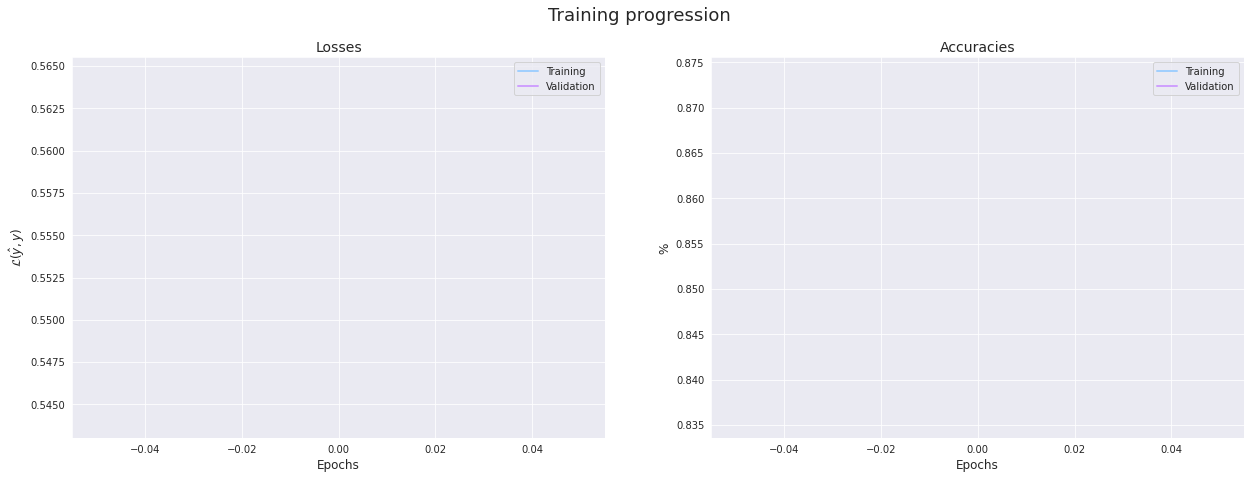

Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' trun

Epoch2/5	Avg Train Loss: 0.538	Train Acc: 0.894165	Avg Val Loss: 0.543	Val Acc: 0.884


Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' trun

Epoch3/5	Avg Train Loss: 0.533	Train Acc: 0.907292	Avg Val Loss: 0.542	Val Acc: 0.884


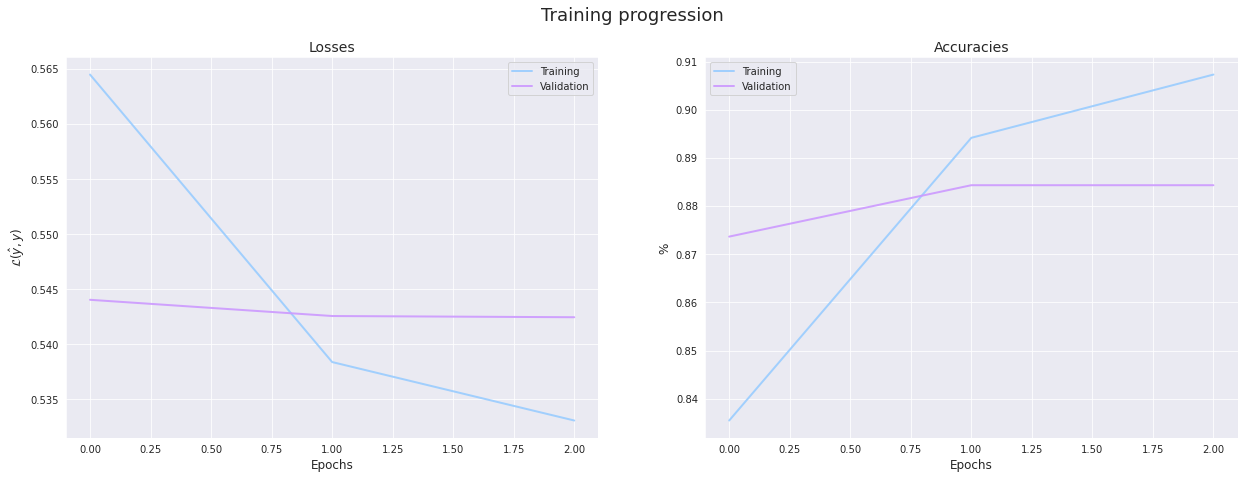

Streaming output truncated to the last 5000 lines.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' trun

Buffered data was truncated after reaching the output size limit.

In [ ]:
train()

In [ ]:
print(alltrain_loss, alltrain_acc, allval_loss, allval_acc)

[0.6738480962052638, 0.5624440129922361, 0.5466402331177069, 0.5417716563964377, 0.5368313971830874] [0.592964824120603, 0.8902676648548867, 0.9069838990872731, 0.9133422213106348, 0.9244180084093939] [0.5909004119726328, 0.5533558818010184, 0.5501529070047232, 0.5452126447971051, 0.546382473065303] [0.8568498769483183, 0.8908941755537325, 0.894585726004922, 0.8995077932731748, 0.8990976210008204]


In [ ]:
#from dateutil import rrule
#from datetime import datetime, timedelta

In [2]:
'''

def get_weeks(start_date, end_date):
    
    #Finds collection of weeks chronologically from a starting date to a final date

    #Input: start_date - date of which to start collecting with format [year, month, day] (type: list of ints)
    #       end_date - date of which to stop collecting with format [year, month, day] (type: list of ints)

    #Output: weeks - list containing the lists of starting and ending date for each week with format
    #                "%Y-%m-%d %h-%m-%s" (type: list of lists of strings)
    
    start_year, start_month, start_day = start_date
    final_year, final_month, final_day = end_date
    start = datetime(start_year, start_month, start_day)
    end = datetime(final_year, final_month, final_day)
    dates = rrule.rrule(rrule.WEEKLY, dtstart=start, until=end)
    nr_weeks = 0
    for _ in dates:
        nr_weeks+=1
    weeks = []
    for idx, dt in enumerate(dates):
        if idx < nr_weeks-1:
            week = [dates[idx].date().strftime('%Y-%m-%d %H:%M:%S'),
                    dates[idx+1].date().strftime('%Y-%m-%d %H:%M:%S')]
            weeks.append(week)

    return weeks
'''

'\n\ndef get_weeks(start_date, end_date):\n    \n    #Finds collection of weeks chronologically from a starting date to a final date\n\n    #Input: start_date - date of which to start collecting with format [year, month, day] (type: list of ints)\n    #       end_date - date of which to stop collecting with format [year, month, day] (type: list of ints)\n\n    #Output: weeks - list containing the lists of starting and ending date for each week with format\n    #                "%Y-%m-%d %h-%m-%s" (type: list of lists of strings)\n    \n    start_year, start_month, start_day = start_date\n    final_year, final_month, final_day = end_date\n    start = datetime(start_year, start_month, start_day)\n    end = datetime(final_year, final_month, final_day)\n    dates = rrule.rrule(rrule.WEEKLY, dtstart=start, until=end)\n    nr_weeks = 0\n    for _ in dates:\n        nr_weeks+=1\n    weeks = []\n    for idx, dt in enumerate(dates):\n        if idx < nr_weeks-1:\n            week = [dates[idx].

In [ ]:

#def predict(testing_loader):
    '''
    Creates, loads and initiates the model and making predictions on the test data

    Input: testdata - data loader of the test data (type: DataLoader)
    Output: preds_prob_list - list of all the probabilities of which the model predicted
                              the corresponding label (type: list of floats)
            preds_status_list - list of all the reencoded labels that were predicted (type: list of strings)
    '''
'''    model.eval()
    fin_targets=[]
    fin_outputs=[]
    losses = []
    total = 0
    correct = 0

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            #outputs = torch.sigmoid(outputs)   #<--- since I use BCEWithLogitsLoss

            #loss = loss_fn(outputs, targets)
            #losses.append(loss.item())
            
            #predicted = torch.round(outputs)
            #total += outputs.shape[0]
            #correct += np.floor_divide((predicted == targets).sum().item(), 2)

        #val_acc = correct / total
        #val_avg_loss = sum(losses) / len(losses)            
            
    return fin_targets, fin_outputs # val_avg_loss, val_acc,
'''    

In [1]:
'''time_to = get_weeks([2019, 12, 24], [2020, 3, 17]) # UK lockdown and 3 months back
time_from = get_weeks([2020, 3, 24], [2020, 6, 24]) # UK lockdown and 3 months forward
test_set_time_spans = []
for tt in time_to:
    test_set_time_spans.append(tt)
for tf in time_from:
    test_set_time_spans.append(tf)
len_timespan = len(test_set_time_spans)

for time_idx in range(1): #range(len_timespan):

  time_data = pd.read_csv('cleaned/all_loc_' + str(time_idx) + '_cleaned.csv')
  time_data.rename(columns={'test docs': 'text'}, inplace=True)
  time_data['labels'] = 0 # have to have label or it won't run

  print(time_data.head(), time_data.tail())

  testing_set = MultiLabelDataset(time_data, tokenizer,  MAX_LEN)

  testing_loader = DataLoader(testing_set, **test_params)
  targets, outputs = predict(testing_loader)
'''

"time_to = get_weeks([2019, 12, 24], [2020, 3, 17]) # UK lockdown and 3 months back\ntime_from = get_weeks([2020, 3, 24], [2020, 6, 24]) # UK lockdown and 3 months forward\ntest_set_time_spans = []\nfor tt in time_to:\n    test_set_time_spans.append(tt)\nfor tf in time_from:\n    test_set_time_spans.append(tf)\nlen_timespan = len(test_set_time_spans)\n\nfor time_idx in range(1): #range(len_timespan):\n\n  time_data = pd.read_csv('cleaned/all_loc_' + str(time_idx) + '_cleaned.csv')\n  time_data.rename(columns={'test docs': 'text'}, inplace=True)\n  time_data['labels'] = 0 # have to have label or it won't run\n\n  print(time_data.head(), time_data.tail())\n\n  testing_set = MultiLabelDataset(time_data, tokenizer,  MAX_LEN)\n\n  testing_loader = DataLoader(testing_set, **test_params)\n  targets, outputs = predict(testing_loader)\n"

In [ ]:
'''
def collect_tweets(keywords = None, nr_tweets = None,
                   output_file=None, timespan=[None, None]):
    
    Collectiing tweets using twint based on different attributes and save to json file

    Input: keywords - keywords that the tweet should contain (type: string)
           nr_tweets - number of tweets to collect (type: int)
           output_file - path and name to where the file should be saved (type: string, extension: .json)
           near - location or city of which the tweets were tweeted (type: string)
           timespan - timespan of when the tweet was tweeted in format "%Y-%m-%d %h-%m-%s" (type: string)

    Output: Returns twint object
    
    # configuration
    config = twint.Config()
    # Search keyword
    config.Search = keywords
    # Language
    config.Lang = "en"
    # Number of tweets
    config.Limit = nr_tweets
    #Dates
    config.Since = timespan[0]
    config.Until = timespan[1]
    config.Geo = "54.251186, -4.463196, 550km"
    # Output file format (alternatives: json, csv, SQLite)
    config.Store_json = True
    # Name of output file with format extension (i.e NAME.json, NAME.csv etc)
    config.Output = output_file

    # running search
    twint.run.Search(config)
    return twint


def get_testdata(paths, save_path, timespans, collect_test_data = False):
    
    Builds vocabulary and encoder based on the training data and collects, clean and builds data loaders
    for the test data

    Input: paths - path to store the collected test data with json extension (type: list of strings)
           save_path - path to where to save the cleaned and final test dataset with csv
                       extension (type: list of strings)
           timespans - timespans of when the collected test tweets where tweeted (type: list of lists of strings)
           collect_test_data - specifying if to collect test data or not (type: boolean)

    Output: test_loader - data loader for the collected test data (type: DataLoader)
            encoder - encoder trained on the training labels (type: LabelEncoder)
            vocab_size - size of the vocabulary built from the training data (type: int)
            n_classes: number of classes/labels from the training data (type: int)
    
    roots, exts = [], []
    for path in paths:
        root, ext = os.path.splitext(path)
        roots.append(root)
        exts.append(ext)
    save_root, save_exts = os.path.splitext(save_path)
    json_paths = [root + '.json' for root in roots]
    csv_path = save_root + '.csv'
    
    if collect_test_data:
        for idx, json_path in enumerate(json_paths):
            tweets = collect_tweets(nr_tweets = 5000, output_file=json_path, timespan=timespans)
            print(tweets)
            !touch "/content/gdrive/My Drive/sample_file.txt"
    testdata, keys = datacleaning(paths = json_paths, labels=[], 
                                  hashtags_to_remove=[],  save_path=csv_path, train=False)

    return test_loader, encoder, vocab_size, n_classes
'''

'def get_weeks(start_date, end_date):\n    \n    #Finds collection of weeks chronologically from a starting date to a final date\n\n    #Input: start_date - date of which to start collecting with format [year, month, day] (type: list of ints)\n    #       end_date - date of which to stop collecting with format [year, month, day] (type: list of ints)\n\n    #Output: weeks - list containing the lists of starting and ending date for each week with format\n    #                "%Y-%m-%d %h-%m-%s" (type: list of lists of strings)\n    \n    start_year, start_month, start_day = start_date\n    final_year, final_month, final_day = end_date\n    start = datetime(start_year, start_month, start_day)\n    end = datetime(final_year, final_month, final_day)\n    dates = rrule.rrule(rrule.WEEKLY, dtstart=start, until=end)\n    nr_weeks = 0\n    for _ in dates:\n        nr_weeks+=1\n    weeks = []\n    for idx, dt in enumerate(dates):\n        if idx < nr_weeks-1:\n            week = [dates[idx].date

In [ ]:
# EXAMPLE
#def test():
#    config = twint.Config()
#    config.Search = 'pineapple'
#    config.Near = "london"
#    config.Lang = "en"
#    config.Limit = 1
#    config.Since = "2016-10-29 00:00:00"
#    config.Until = "2016-11-29 12:15:19"
#    config.Store_json = True
#    config.Output = "test.json"

    #running search
#    twint.run.Search(config)

#t = test()

In [ ]:
'''
class config:
    
    Configuration class to store and tune global variables
    
    paths = ['./training_data/depressive1.json',
             './training_data/depressive2.json',
             './training_data/depressive3.json',
             './training_data/depressive4.json',
             './training_data/depressive5.json',
             './training_data/depressive6.json',
             './training_data/non-depressive1.json',
             './training_data/non-depressive2.json',
             './training_data/non-depressive3.json',
             './training_data/non-depressive4.json',
             './training_data/non-depressive5.json',
             './training_data/non-depressive6.json']

    labels = ['depressive', 'depressive', 'depressive', 'depressive', 'depressive', 'depressive',
              'not-depressive', 'not-depressive', 'not-depressive', 'not-depressive',
              'not-depressive', 'not-depressive']

    save_path = './training_data/all_training_data.csv'
    keywords = ['depressed', 'lonely', 'sad', 'depression', 'tired', 'anxious',
                'happy', 'joy', 'thankful', 'hope', 'hopeful', 'glad']
    nr_of_tweets = [5000, 5000, 5000, 5000, 5000, 5000,
                    5000, 5000, 5000, 5000, 5000, 5000]
    hashtags_to_remove = []
    encoder = None
    vocab = None
    vocab_size = 0
    n_classes = 0

def collect_dataset(paths, keywords, nr_of_tweets, hashtags_to_remove, collect=True):
    
    Collecting the dataset and cleans the data

    Input: paths - path to where to save the collected tweets (type: list of strings)
           keywords - keywords to be used for collecting tweets (type: list of strings)
           nr_of_tweets - number of tweets to be collected for each collecting process (type: list of ints)
           collect - specifying if to collect tweets or not (type: boolean)

    Output: dataset - cleaned dataset of the tweet texts and their labels (type: list if lists)
    
    roots, exts = [], []
    for path in paths:
        root, ext = os.path.splitext(path)
        roots.append(root)
        exts.append(ext)
    #roots, exts = [os.path.splitext(path) for path in paths]
    save_root, save_exts = os.path.splitext(config.save_path)
    json_paths = [root+'.json' for root in roots]
    csv_path = save_root+'.csv'
    if collect:
        for idx, json_path in enumerate(json_paths):
            collect_tweets(keywords=keywords[idx], nr_tweets=nr_of_tweets[idx], output_file=json_path)

    dataset, keys = datacleaning(paths=json_paths, labels=config.labels, hashtags_to_remove=hashtags_to_remove,
                                                    save_path=csv_path)

    return dataset, keys
'''

In [ ]:
'''def load_json(path):
    
    Loads collected data in json format, checks it and then converts to csv format

    Input: path - path and file name to the collected json data (type: string)

    Output: keys - list of features/keys of the dataframe (type: list of strings)
            df_list - list containing all the dataframes from the json data (type: list of dataframes)
    
    if not path.endswith('.json'):
        print('File path not JSON file...')
        return None

    with open(path, 'r', encoding='utf8') as handle:
        df_list = [json.loads(line) for line in handle]

    nr_keys = [len(df_list[i].keys()) for i in range(len(df_list))]
    if not all(k == nr_keys[0] for k in nr_keys):
        print('Some features missing, review the data!')
        return None

    else:
        keys = df_list[0].keys()
        return keys, df_list


def combine_and_label(paths, labels, train=True):
    
    Combining multiple collections of data files and adds corresponding label (i.e depressive or non-depressive).
    List of labels in correct order with respect to the paths order must be specified manually

    Input: paths - list containing all the paths to the json files (type: list of strings)
           labels - list containing all the labels to the corresponding json files (type: list of strings)

    Output: df_list - list of all the combined dataframes from the json data (type: list of dataframes)
    

    if not type(paths)==type(list()):
        print('"paths" argument is not of type list! Please pass list of the paths to the collected data to be combined!')
        return None
    if train:
        if not len(paths) == len(labels):
            print(f'Number of datafile paths of {len(paths)} is not the same as number of labels of {len(labels)}!')
            return None

    df_list = []
    for idx, path in enumerate(paths):
        try:
            curr_keys, curr_df_list = load_json(path)
        except Exception as e:
            print(f'Unable to load data from path "{path}", check path name and file!')
            print(f'Exception:\n{e}')
            return None
        for df in curr_df_list:
            if train:
                df['label'] = labels[idx]
            df_list.append(df)

    return df_list


def datacleaning(paths, labels, hashtags_to_remove = [], save_path=None, train=True):
    
    Cleans the data based on unwanted hashtags, duplication of tweets occured due
    to sharing of keywords, removal of mentions, urls, non-english alphabetic tokens
    and empty tweets obtained after cleaning

    Input: paths - list containing all the paths to the json files (type: list of strings)
           labels - list containing all the labels to the corresponding json files (type: list of strings)
           hashtags_to_remove - list containing hashtags wished to be removed (type: list of strings)
           save_path - path and file name to were to save the cleaned dataset (type: string or None)
           train - specify if it is training mode or not, i.e if to use labels or not (type: boolean)

    Output: dataset_doc - list of all the text documents and corresponding labels if train (type: list of strings)
            keys - list of features/keys of the dataframe (type: list of strings)

    
    if len(labels) > 0:
        train = True

    df_list = combine_and_label(paths, labels, train=train)

    # Remove tweets with specific hashtags
    nr_removed_tweets = 0
    for idx, df in enumerate(df_list):
        hashtags = df.copy()['hashtags']
        if any([h in hashtags_to_remove for h in hashtags]):
            df_list.pop(idx)
            print(f'Tweet nr {idx} removed!')
            nr_removed_tweets += 1

    print(f'Removed total of {nr_removed_tweets} tweets')

    # Removes duplicate of tweets
    unique_ids = {}
    for idx, df in enumerate(df_list):
        tweet_id = df.copy()['id']
        if not tweet_id in unique_ids:
            unique_ids[str(tweet_id)] = 1
        else:
            print('Found douplicate of tweet id, removing the duplicate!')
            df_list.pop(idx)


    # Cleaning the tweet texts
    for idx, df in enumerate(df_list):
        tweet = df.copy()['tweet']
        # Removing URLs
        tweet = re.sub(r"http\S+", " ", tweet)
        tweet = re.sub(r"\S+\.com\S", " ", tweet)

        # Remove mentions
        tweet = re.sub(r'\@\w+', ' ', tweet)

        # Remove non-alphabetic tokens
        tweet = re.sub('[^A-Za-z]', ' ', tweet.lower())

        # Remove double spacings
        tweet = re.sub(' +', ' ', tweet)

        # Remove from dataset if tweet empty after cleaning
        if tweet == 0:
            df_list.pop(idx)
        else:
            df['tweet'] = tweet

    print('Successfully cleaned data!')

    # Saving list of tweet dicts to csv format

    if save_path:
        print(f'Saving data...')
        if not save_path.endswith('.csv'):
            print('Save path is missing .csv format extension!')
            save_path = save_path + '.csv'
        try:
            with open(save_path, 'w', encoding='utf8', newline='') as output_file:
                csv_file = csv.DictWriter(output_file,
                                          fieldnames=df_list[0].keys(),
                                          )

                csv_file.writeheader()
                csv_file.writerows(df_list)
                print(f'Data succesfully saved to "{save_path}"')

        except Exception as e:
            print(f'Unable to save data to "{save_path}", check the path and data!')
            print(f'Exception:\n{e}')

    dataset_docs = [df['tweet'] for df in df_list]
    keys = df_list[0].keys()
    if train:
        dataset_labels = [df['label'] for df in df_list]
        return [dataset_docs, dataset_labels], keys
    else:
        return dataset_docs, keys
'''

In [ ]:
#def get_testdata(paths, save_path, timespans, collect_test_data = False):
'''
ind_paths = ['./training_data/depressive1.json',
             './training_data/depressive2.json',
             './training_data/depressive3.json',
             './training_data/depressive4.json',
             './training_data/depressive5.json',
             './training_data/depressive6.json',
             './training_data/non-depressive1.json',
             './training_data/non-depressive2.json',
             './training_data/non-depressive3.json',
             './training_data/non-depressive4.json',
             './training_data/non-depressive5.json',
             './training_data/non-depressive6.json']

save_path = './training_data/all_training_data.csv'

time_to = get_weeks([2019, 12, 24], [2020, 3, 24]) # UK lockdown and 3 months back
time_from = get_weeks([2020, 3, 24], [2020, 6, 24]) # UK lockdown and 3 months forward
test_set_time_spans = []
for tt in time_to:
    test_set_time_spans.append(tt)
for tf in time_from:
    test_set_time_spans.append(tf)
len_timespan = len(test_set_time_spans)

#print(test_set_time_spans)
  
testdata, encoder, vocab_size, n_classes = get_testdata(ind_paths, save_path,
                                            timespans = test_set_time_spans[0],
                                            collect_test_data = True)
'''

"\nind_paths = ['./training_data/depressive1.json',\n             './training_data/depressive2.json',\n             './training_data/depressive3.json',\n             './training_data/depressive4.json',\n             './training_data/depressive5.json',\n             './training_data/depressive6.json',\n             './training_data/non-depressive1.json',\n             './training_data/non-depressive2.json',\n             './training_data/non-depressive3.json',\n             './training_data/non-depressive4.json',\n             './training_data/non-depressive5.json',\n             './training_data/non-depressive6.json']\n\nsave_path = './training_data/all_training_data.csv'\n\ntime_to = get_weeks([2019, 12, 24], [2020, 3, 24]) # UK lockdown and 3 months back\ntime_from = get_weeks([2020, 3, 24], [2020, 6, 24]) # UK lockdown and 3 months forward\ntest_set_time_spans = []\nfor tt in time_to:\n    test_set_time_spans.append(tt)\nfor tf in time_from:\n    test_set_time_spans.append(tf)\nlen_

In [ ]:
'''
data, keys = collect_dataset(paths=config.paths, keywords=config.keywords,
                           nr_of_tweets=config.nr_of_tweets,
                           hashtags_to_remove=config.hashtags_to_remove,
                           collect=True)
X, Y = data
'''

'\ndata, keys = collect_dataset(paths=config.paths, keywords=config.keywords,\n                           nr_of_tweets=config.nr_of_tweets,\n                           hashtags_to_remove=config.hashtags_to_remove,\n                           collect=True)\nX, Y = data\n'